In [13]:
using PyPlot
using PyCall
np = pyimport("numpy")
using HDF5
using CosmoMMF
using Revise
using YAML
using JLD2

@pyimport mpl_toolkits.axes_grid1 as axgrid
plt.style.use("dark_background")
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["font.size"] = 22
config = YAML.load_file("config.yaml")

Dict{Any, Any} with 9 entries:
  "n"                  => 1024
  "output_directory"   => "output_files/"
  "snapshot_directory" => "../../../../global/cscratch1/sd/jialiu/NEXUS_TNG/300…
  "num_snaps"          => 4
  "snapfile_root"      => 99
  "algorithm"          => "NEXUS+"
  "xmax"               => 205000.0
  "xmin"               => 0.0
  "num_scales"         => 10

# Load in Data File to Apply Nexus+ On

Note, we can't apply NEXUS+ directly to the data file, we need to create a grid mesh of the data using nbodykit. We also need to make sure there isn't any 0's in our mesh because it will break the NEXUS+ method.

In [3]:
output_directory = config["output_directory"]

"output_files/"

In [4]:
@load output_directory * "99" * ".jld2" den

1-element Vector{Symbol}:
 :den

In [5]:
############################################################
# TNG-300-3-Dark specifications (From Illustris website)
############################################################
# TNG300-3 specifications
DM_particle_mass = 0.302538487429177 # in units of 1e10 Msun/h
N_DM = 244140625
N_cells = size(den,1) * size(den,2) * size(den,3)
# an average grid cell has 
mass_of_average_cell = DM_particle_mass * N_DM / N_cells

#----------------------------------------------------------

############################################################
# Illustris-3 specifications (From Illustris website)
############################################################

# DM_particle_mass = 0.0282173775591101 # in units of 1e10 Msun/h
# N_DM = 94196375

# #We divide the sim up into cells in the form of a gridmesh using NBodyKit
# #N_cells = size(den,1) * size(den,2) * size(den,3)

# # an average grid cell has 
# mass_of_average_cell = DM_particle_mass * N_DM / N_cells

# #subbox_buffer = 64
# #run_name = "TNG300-3_1024"
# xmin = 0.0
# xmax = 75000.0 #in units of ckpc/h where h = 0.704
# #num_scales = 10
# #output_directory = "/media/data/TNG/300-3-Dark/out/"
# #nx = 1024
# snapshot_directory = "../../../cscratch1/sd/james12/Illustris-3/output/snapdir_135/"
# #num_snaps = 4
# snapfile_root = 135

# #number_subboxes = 2

0.06878928784980803

# Run NEXUS+ on Our Density Cube

First let's examine the snapshot without any smoothing

In [6]:
# utility function for plotting
function plot_square(arr; 
        xmin=config["xmin"], xmax=config["xmax"], 
        ax=nothing, vmin=1e-2, vmax=2)
    if ax == nothing
        fig, ax = subplots(figsize=(9,9))
    end
    step = (xmax-xmin)/(size(arr)[1]+1)
    xg = collect( xmin+step/2:step:xmax-step )
    xyswapped = permutedims( arr, [2,1])
    ax[:pcolormesh]( xg,xg, xyswapped, vmin=vmin, vmax=vmax ) # in matplotlib, y is first
    return ax
end

plot_square (generic function with 1 method)

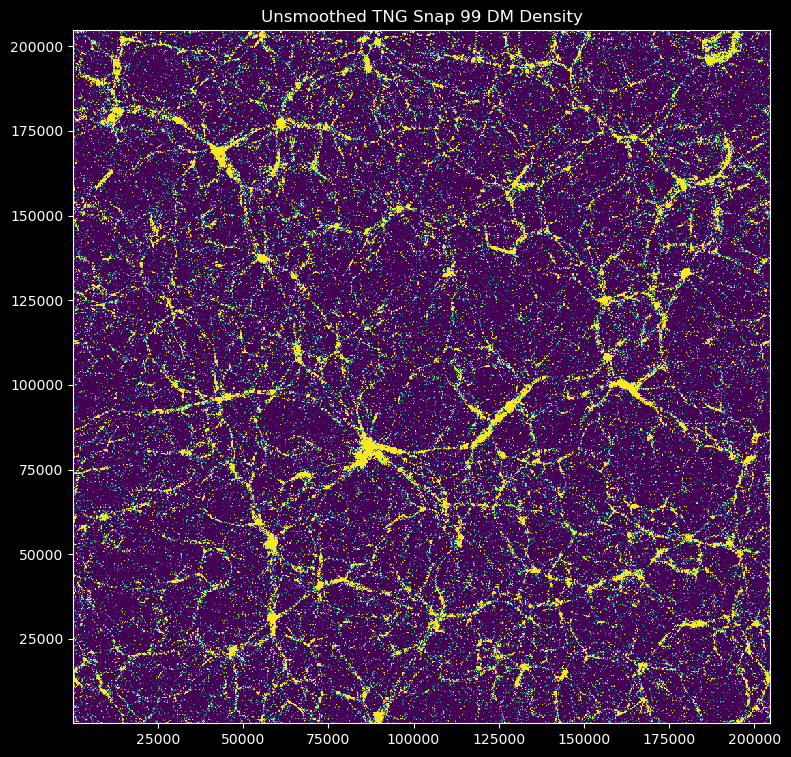

In [105]:
plot_square(den[:,:,256])
plt.title("Unsmoothed TNG Snap 99 DM Density")
plt.show()

# print(np.shape(den))

In [107]:
np.max(den)
np.std(den)

21.331382751464844

## Test out log smoothing on density field

In [55]:
# n = config["n"]
wave_vecs = CosmoMMF.wavevectors3D(Float64,(256,256,256))
# print(typeof(wave_vecs))
density_field = den[1:256,1:256,1:256]
# print(density_field[128:156,128:156,256])
density_field=Float64.(density_field)
# print("\n\n\n")
# print(density_field[128:156,128:156,256])
density_field = density_field .+ 0.0001 #this is a bit of a temporary solution

print("Removing any 0.0 values in the density field.")

Removing any 0.0 values in the density field.

In [117]:
start_time = time()
smoothed_TNG = CosmoMMF.smooth_loggauss(density_field, 2.0, wave_vecs)
finish_time = time()

print("The time it takes to apply a log-gauss smoothing filter is ")
print(finish_time - start_time, " seconds")

The time it takes to apply a log-gauss smoothing filter is 7.713351011276245 seconds

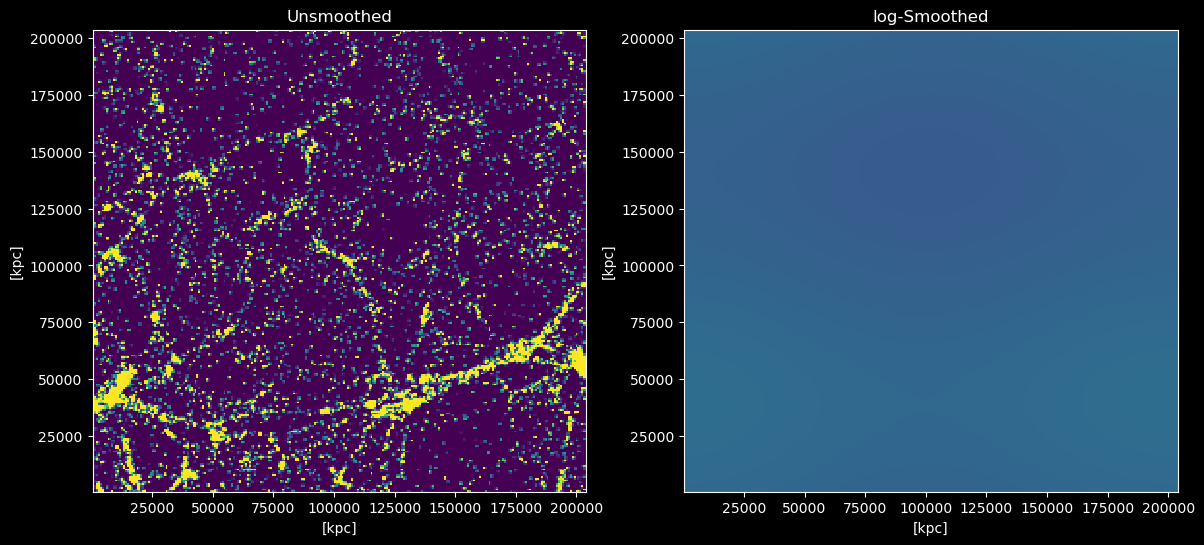

Yay! Log Gaussian Smoothing Works on TNG!

In [118]:
f = plt.figure(figsize=(14,6))
# f.suptitle("Density Fields - smoothed", fontsize=30)
#top left
ax1 = plt.subplot(121)
plot_square(density_field[:,:,128], ax=ax1)
ax1.set_title("Unsmoothed")
ax1.set_xlabel("[kpc]")
ax1.set_ylabel("[kpc]")
#top right
ax2 = plt.subplot(122)
plot_square(smoothed_TNG[:,:,128], ax=ax2)
ax2.set_title("log-Smoothed")
ax2.set_xlabel("[kpc]")
ax2.set_ylabel("[kpc]")
#plt.savefig("Smoothing_Comparison.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

print("""Yay! Log Gaussian Smoothing Works on TNG!""")

## Calculate the Hessian for the Log-Smoothed Density Field

In [84]:
start_time = time()
Hessian_TNG = CosmoMMF.hessian_NEXUSPLUS(density_field, 0.5, wave_vecs)
finish_time = time()

print("The time it takes to calculate the Hessian is ")
print(finish_time - start_time, " seconds")



The time it takes to calculate the Hessian is 23.246953010559082 seconds

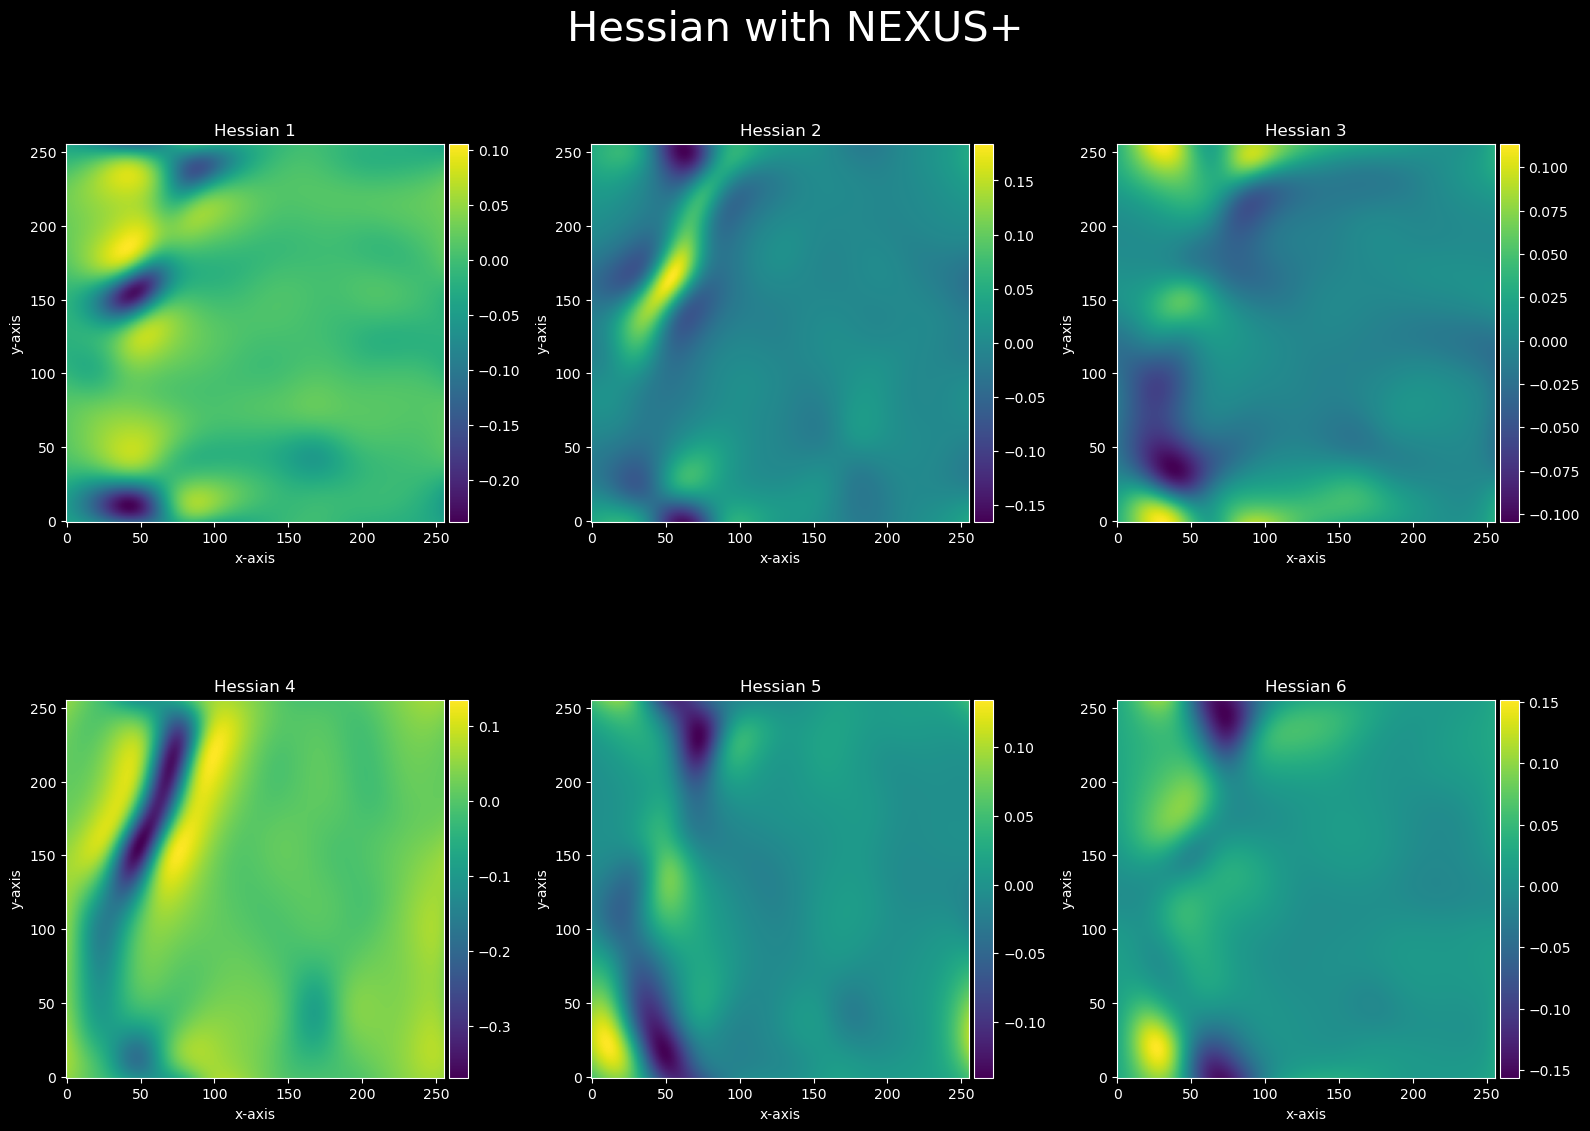

In [116]:
f = plt.figure(figsize=(16,12))
f.suptitle("Hessian with NEXUS+", fontsize=30)
#top left
ax1 = plt.subplot(231)
#plot_square(Hessian_TNG[:,:,128,1], ax=ax1)
#ax1.imshow(Hessian_TNG[:,:,128,1], origin="lower", vmin=-0.05, vmax=0.05)
ax1.set_title("Hessian 1")
ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")
im1 = ax1.imshow(Hessian_TNG[:,:,128,1], origin="lower")
divider1 = axgrid.make_axes_locatable(ax1)
cax1 = divider1[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
#top middle
ax2 = plt.subplot(232)
#plot_square(Hessian_TNG[:,:,128,2], ax=ax2)
# ax2.imshow(Hessian_TNG[:,:,128,2], origin="lower")
ax2.set_title("Hessian 2")
ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
im2 = ax2.imshow(Hessian_TNG[:,:,128,2], origin="lower")
divider2 = axgrid.make_axes_locatable(ax2)
cax2 = divider2[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)
#top right
ax3 = plt.subplot(233)
#plot_square(Hessian_TNG[:,:,128,3], ax=ax3)
# ax3.imshow(Hessian_TNG[:,:,128,3], origin="lower")
ax3.set_title("Hessian 3")
ax3.set_xlabel("x-axis")
ax3.set_ylabel("y-axis")
im3 = ax3.imshow(Hessian_TNG[:,:,128,3], origin="lower")
divider3 = axgrid.make_axes_locatable(ax3)
cax3 = divider3[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)

#left
ax4 = plt.subplot(234)
#plot_square(Hessian_TNG[:,:,128,4], ax=ax4)
# ax4.imshow(Hessian_TNG[:,:,128,4], origin="lower")
ax4.set_title("Hessian 4")
ax4.set_xlabel("x-axis")
ax4.set_ylabel("y-axis")
im4 = ax4.imshow(Hessian_TNG[:,:,128,4], origin="lower")
divider4 = axgrid.make_axes_locatable(ax4)
cax4 = divider4[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im4, cax=cax4)
#middle
ax5 = plt.subplot(235)
#plot_square(Hessian_TNG[:,:,128,5], ax=ax5)
# ax5.imshow(Hessian_TNG[:,:,128,5], origin="lower")
ax5.set_title("Hessian 5")
ax5.set_xlabel("x-axis")
ax5.set_ylabel("y-axis")
im5 = ax5.imshow(Hessian_TNG[:,:,128,5], origin="lower")
divider5 = axgrid.make_axes_locatable(ax5)
cax5 = divider5[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im5, cax=cax5)
#right
ax6 = plt.subplot(236)
#plot_square(Hessian_TNG[:,:,128,6], ax=ax6)
# ax6.imshow(Hessian_TNG[:,:,128,6])
ax6.set_title("Hessian 6")
ax6.set_xlabel("x-axis")
ax6.set_ylabel("y-axis")
im6 = ax6.imshow(Hessian_TNG[:,:,128,6], origin="lower")
divider6 = axgrid.make_axes_locatable(ax6)
cax6 = divider6[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im6, cax=cax6)
plt.tight_layout()

# Detect Signatures

In [86]:
start_time = time()
signatures_TNG = CosmoMMF.signatures_from_hessian(Hessian_TNG)
finish_time = time()

print("The time it takes to calculate the signatures from the hessian is ")
print(finish_time - start_time, " seconds")

The time it takes to calculate the signatures from the hessian is 10.102654933929443 seconds

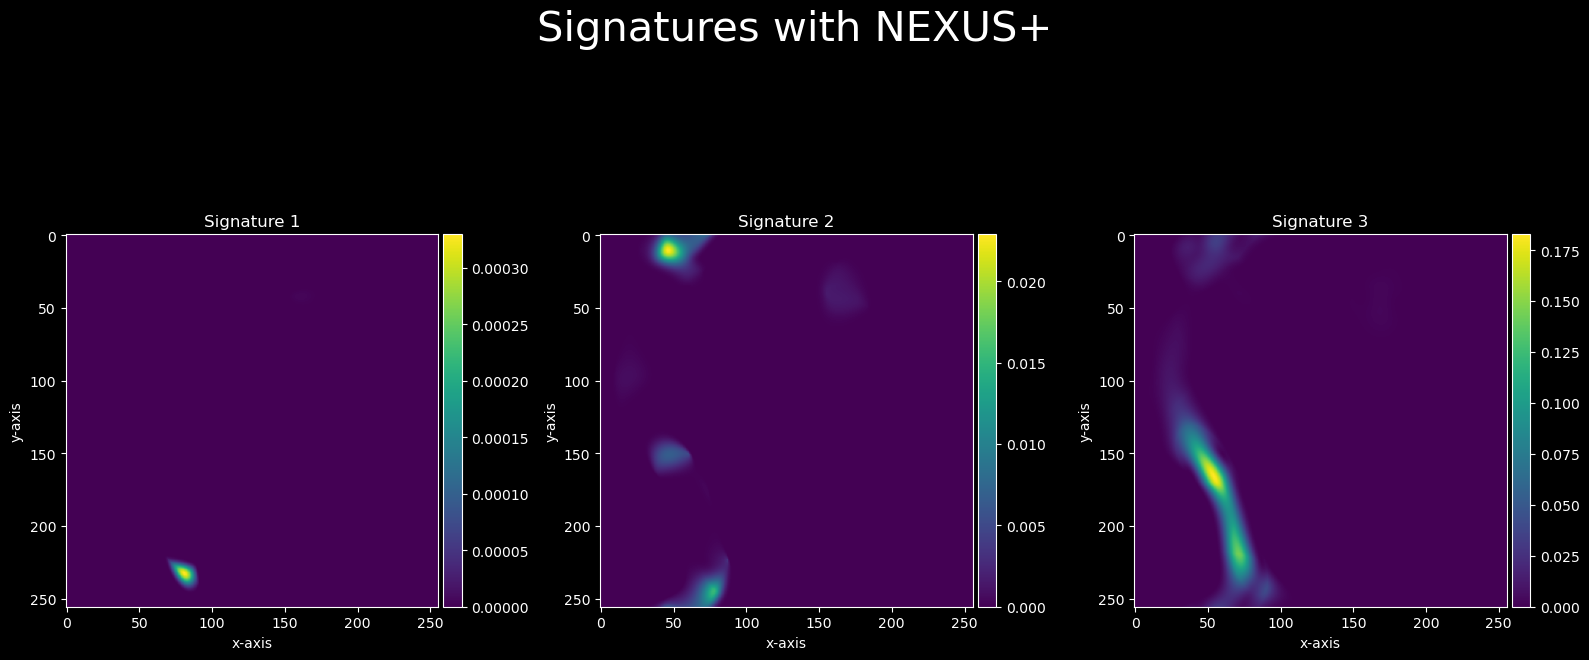

In [87]:
f = plt.figure(figsize=(16,6))
f.suptitle("Signatures with NEXUS+", fontsize=30)
#top left
ax1 = plt.subplot(131)
#plot_square(Hessian_TNG[:,:,128,1], ax=ax1)
ax1.imshow(signatures_TNG[:,:,128,1], origin="lower")
ax1.set_title("Signature 1")
ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")
im1 = ax1.imshow(signatures_TNG[:,:,128,1])
divider1 = axgrid.make_axes_locatable(ax1)
cax1 = divider1[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
#top middle
ax2 = plt.subplot(132)
#plot_square(Hessian_TNG[:,:,128,2], ax=ax2)
ax2.imshow(signatures_TNG[:,:,128,2], origin="lower")
ax2.set_title("Signature 2")
ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
im2 = ax2.imshow(signatures_TNG[:,:,128,2])
divider2 = axgrid.make_axes_locatable(ax2)
cax2 = divider2[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)
#top right
ax3 = plt.subplot(133)
#plot_square(Hessian_TNG[:,:,128,3], ax=ax3)
ax3.imshow(signatures_TNG[:,:,128,3], origin="lower")
ax3.set_title("Signature 3")
ax3.set_xlabel("x-axis")
ax3.set_ylabel("y-axis")
im3 = ax3.imshow(signatures_TNG[:,:,128,3])
divider3 = axgrid.make_axes_locatable(ax3)
cax3 = divider3[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)
plt.tight_layout()

Note For Jia: Not entirely sure whether or not this is 100% working. In particular, zack uses a smoothing scale a factor of 10 larger and we get very different results for our Hessians. Part of me simply just thinks this is an artifact of me taking `den[1:256, 1:256, 1:256]` as my density field. I think if I applied this to the whole box we would see a bit nicer results

The signatures and hessian functions are super sensitive to smoothing scales. I think the best have been between 0.5 and 1.5

# Calculate the maximum signatures over a range of smoothing scales

In [99]:
start_time = time()
max_sig_TNG = CosmoMMF.maximum_signature(1.5, density_field)
finish_time = time()

print("The time it takes to calculate the maximum signatures for a density field is ")
print(finish_time - start_time, " seconds")

The time it takes to calculate the maximum signatures for a density field is 226.92494797706604 seconds

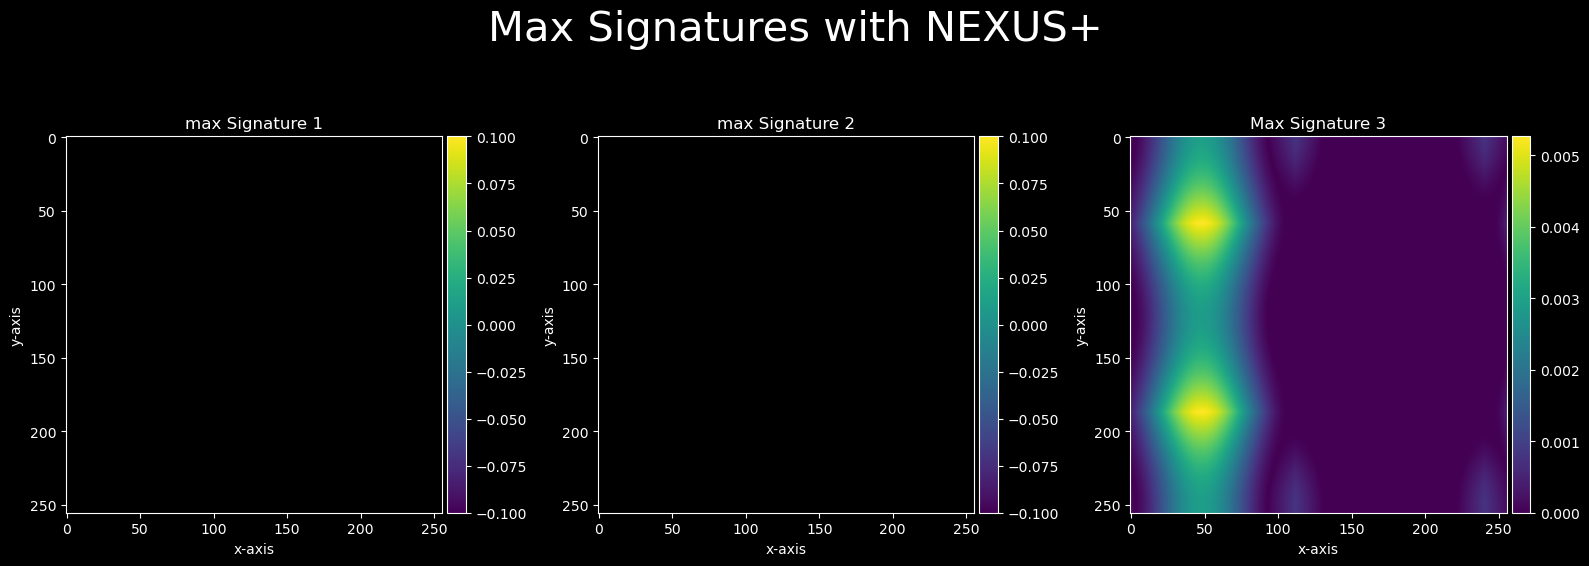

In [102]:
f = plt.figure(figsize=(16,6))
f.suptitle("Max Signatures with NEXUS+", fontsize=30)
#top left
ax1 = plt.subplot(131)
#plot_square(Hessian_TNG[:,:,128,1], ax=ax1)
ax1.imshow(max_sig_TNG[:,:,128,1], origin="lower")
ax1.set_title("max Signature 1")
ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")
im1 = ax1.imshow(max_sig_TNG[:,:,128,1])
divider1 = axgrid.make_axes_locatable(ax1)
cax1 = divider1[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
#top middle
ax2 = plt.subplot(132)
#plot_square(Hessian_TNG[:,:,128,2], ax=ax2)
ax2.imshow(max_sig_TNG[:,:,128,2], origin="lower")
ax2.set_title("max Signature 2")
ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
im2 = ax2.imshow(max_sig_TNG[:,:,128,2])
divider2 = axgrid.make_axes_locatable(ax2)
cax2 = divider2[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)
#top right
ax3 = plt.subplot(133)
#plot_square(Hessian_TNG[:,:,128,3], ax=ax3)
ax3.imshow(max_sig_TNG[:,:,128,3], origin="lower")
ax3.set_title("Max Signature 3")
ax3.set_xlabel("x-axis")
ax3.set_ylabel("y-axis")
im3 = ax3.imshow(max_sig_TNG[:,:,128,3])
divider3 = axgrid.make_axes_locatable(ax3)
cax3 = divider3[:append_axes]("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)
#plt.savefig("max_sigs_NEXUS+_RS_1.5.png", format="png", dpi=300, bbox_inches="tight")
plt.tight_layout()

# Determine Clusters

This needs to be done first because clusters can be burried inside filaments and sheets. We apply a boolean filter over the entire data file by saying that the cluster signature (given by NEXUS+) needs to be greater than a specified threshold `threshold`, we call this function `cluster_bool_filter(threshold)`

In [ ]:
function get_clusbools(thresh) 
    # step 1. make a boolean grid
    test_bools = (combined_NEXUS[:,:,:,1] .> thresh)

    # step 2. tag components
    components = Images.label_components(test_bools)
    max_component = maximum(components)

    print("Components: $(max_component)\n")
    
    # step 3. loop through each component, assess average overdensity
    masses = zeros(Float64, max_component)
    volume = zeros(Float64, max_component)

    nx = size(den::Array{Float32,3})[1]
    compare = zeros(nx,nx,nx);

    for i in 1:nx
        for j in 1:nx
            for k in 1:nx
                if components[i,j,k] != 0
                    masses[ components[i,j,k] ] += (den::Array{Float32,3})[i,j,k]
                    volume[ components[i,j,k] ] += 1.0
                end
            end
        end
    end
    
    compbool = (masses .> 5e3 / mass_of_average_cell)  .& (volume .> 1)
    println( "viri frac:", sum( (volume .> 1) .& (masses ./ volume .> 370) ) / max_component)
    println( "mass frac:", sum(masses[compbool])   / sum(den) )
    
    clusbool = zeros(Bool, nx, nx, nx)
#     good_components = components[clusbool]
    for i in 1:1024
        for j in 1:1024
            for k in 1:1024
                if components[i,j,k] != 0
                    if compbool[components[i,j,k]]
                        clusbool[i,j,k] = true
                    end
                end
            end
        end
    end
    
    clusbool
end

# Determine Filaments

# Determine Sheets